In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
import seaborn as sns

# 1. Single process example (showcasing a new view on unobservability)

This example illustrates the nature of unobservability, of flow rate measurements (for a steady-state process), for the process diagram below. Only Stream 1 is measured and the split between Streams 2 and 3 will be unknown in the mass balance probability distribution model setup. Analytical solution(s) (where obtainable), trapezoidal and MCMC integration approximations for marginals are prepared. 

The mass balance for the process under consideration is (in t/h):
 - $\dot{m}_1 = \dot{m}_2 + \dot{m}_3 \rightarrow 0 = \dot{m}_1 - \dot{m}_2 - \dot{m}_3 \rightarrow 0 = \begin{bmatrix} 1 & -1 & -1 \end{bmatrix} \begin{bmatrix} \dot{m}_1 \\ \dot{m}_2 \\ \dot{m}_3 \end{bmatrix} $

<img src="Balance_example.png" width=260>

Flow rate state variables are $X=[x_1,x_2,x_3]$ and the flow measurement for $x_1$ is $y$. The incidence matrix is $M=[1,-1,-1]$, measurement variance is $\sigma^2$ and mass balance error variance is $\sigma_e^2$. Upper and lower bounds for $X$ are $\alpha=[a_1,a_2,a_3]$ and $\beta=[b_1,b_2,b_3]$. Also, $\alpha$ and $\beta$ give the bounds for the posterior distribution's domain $\Omega$.
 - Likelihood distribution $\rightarrow P(y|x_1, \sigma, I) = \frac{1}{\sqrt{2 \pi \sigma^2}} \cdot e^{-(y-x_1)^2/(2\sigma^2)}$
 - Mass balance prior $\rightarrow P(0|X, M, \sigma_e, I) = \frac{1}{\sqrt{2 \pi \sigma_e^2}} \cdot e^{-(0-MX)^2/(2\sigma_e^2)}$
 - Uniform flow prior(s) $\rightarrow U(X|\alpha,\beta, I) = \prod_i{\frac{1}{b_i - a_i}}$

Mass balance posterior distribution is $P(X|y,\sigma,\sigma_e, \alpha, \beta, I) = P(y|x_1, \sigma, I) \times P(0|X, M, \sigma_e, I) \times U(X|\alpha,\beta, I)$. Substituting the defined terms gives $P(X|y,\sigma,\sigma_e, \alpha, \beta, I) = \frac{1}{\sqrt{2 \pi \sigma^2}} \frac{1}{\sqrt{2 \pi \sigma_e^2}} \prod_i{\frac{1}{b_i - a_i}} e^{-(y-x_1)^2/(2\sigma^2)} e^{-(0-x_1+x_2+x_3)^2/(2\sigma_e^2)}$. An integral (along any combination of $x_1$, $x_2$ or $x_3$) of $P(X|y,\sigma,\sigma_e, \alpha, \beta, I)$ will not have closed-form (analytical) solutions; however, marginals of $P(y|x_1, \sigma, I) \times P(0|X, M, \sigma_e, I)$ have closed-form expressions - these will be compared to the numerical approximations below.

In [2]:
# Assign variance values, measurement value and variable limits
sig = 0.1
sig_e = 0.0001
y = 1.5
a_1,a_2,a_3 = [0,0,0]
b_1,b_2,b_3 = [3,3,3]

In [3]:
'''Trapezoidal method'''
grid_pts = 100
X1_g,X2_g,X3_g = np.meshgrid(np.linspace(a_1,b_1,grid_pts),np.linspace(a_2,b_2,grid_pts),np.linspace(a_3,b_3,grid_pts))
P_ = []
# Calculate posterior probabilities on meshgrid
for i,j,k in zip(X1_g.flatten(), X2_g.flatten(), X3_g.flatten()):
    P_.append( np.exp(-((y-i)**2)/(2*sig)) * np.exp(-((0-i+j+k)**2)/(2*sig_e)) )

# numerically approximate the normalising constant (i.e. evidence term)
X2_c,X3_c = np.meshgrid(np.linspace(a_2,b_2,grid_pts),np.linspace(a_3,b_3,grid_pts))
P_E_trapz = np.trapezoid(
    np.trapezoid( 
        np.trapezoid(np.array(P_).reshape(X1_g.shape).T, x=X1_g, axis=1), x=X2_c, axis=1
        ), x=np.linspace(a_3,b_3,grid_pts), axis=0) 
P_ = np.array(P_)/P_E_trapz

In [4]:
'''MCMC method'''
def log_prob(par):
    if sum( (np.array(par)>0)&(np.array(par)<3) )==3:
        prob = -((y-par[0])**2)/(2*sig) + -((0-par[0]+par[1]+par[2])**2)/(2*sig_e) # probs in log form (ignoring constant term)
    else:
        prob = -1e+120
    return prob

x0 = [a_1 + (b_1-a_1)/2,a_2 + (b_2-a_2)/2,a_3 + (b_3-a_3)/2] # MC start points
xi = x0
samp_res = []
for i in range(1500000):
    u = np.random.uniform(0,1)
    sel_x = np.array([np.random.uniform(i-0.29,i+0.29) for i in xi])
    p_x_prev = log_prob(xi)
    p_x = log_prob(sel_x)
    if np.log(u) < min(0, p_x-p_x_prev): # select new point in MC
        xi = sel_x
        samp_res.append([i for i in xi])
    else:
        samp_res.append([i for i in xi])
        continue
# plt.plot(np.array(samp_res)) # used as a diagnostic

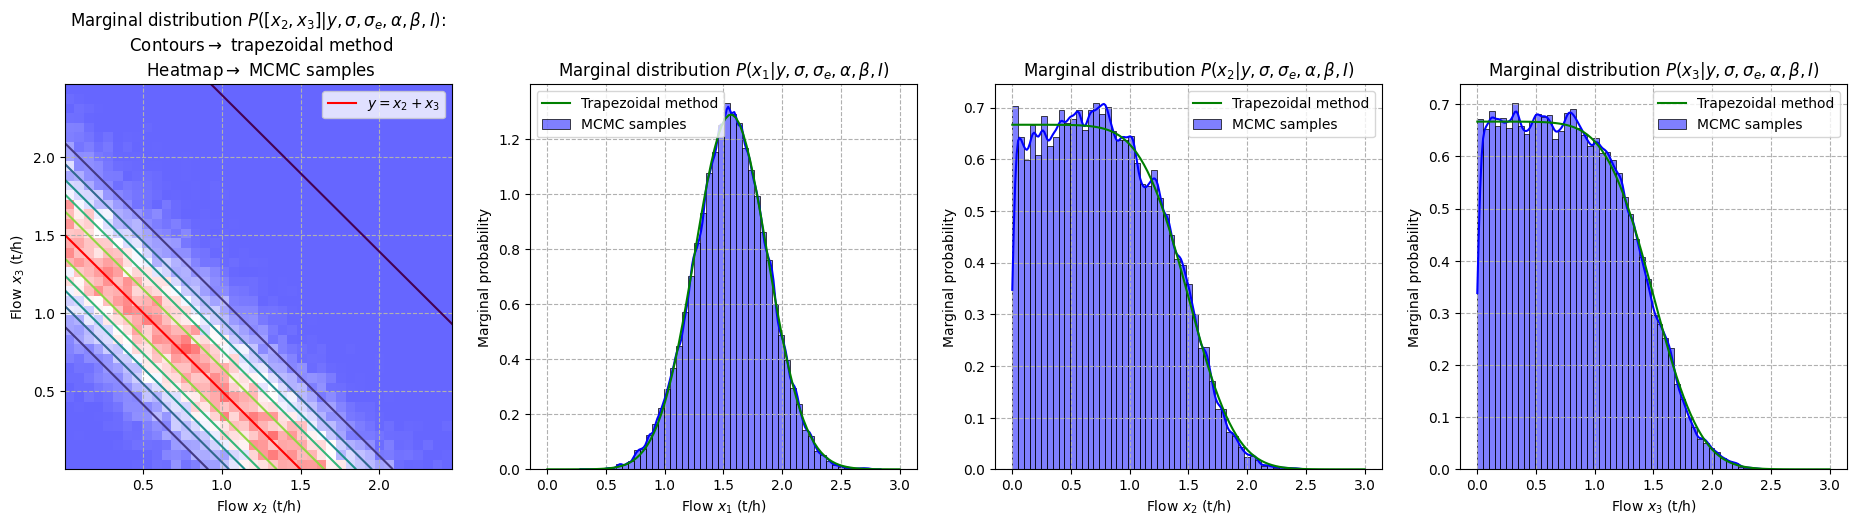

In [5]:
X2_,X3_ = np.meshgrid(np.linspace(a_2,b_2,grid_pts),np.linspace(a_3,b_3,grid_pts))
fig,axx = plt.subplots(1,4,figsize=(23.,5.))
axx[0].contour( X2_, X3_, np.trapezoid(P_.reshape(X1_g.shape).T, x=X1_g, axis=1) )
axx[0].hist2d(np.array(samp_res)[:,1], np.array(samp_res)[:,2], bins=40, density=True, cmap='bwr', alpha=0.6)
axx[0].plot(np.linspace(a_2,y,300), -1.0*np.linspace(a_2,y,300)+y, 'r', label='$y=x_2+x_3$')
axx[0].legend(), axx[0].grid(ls='--')
axx[0].set_xlabel('Flow $x_2$ (t/h)'), axx[0].set_ylabel('Flow $x_3$ (t/h)')
axx[0].set_title(r'Marginal distribution $P([x_2, x_3]|y,\sigma,\sigma_e, \alpha, \beta, I)$:'+'\n Contours'+r'$\rightarrow$ trapezoidal method'+'\n Heatmap'+r'$\rightarrow$ MCMC samples')

sns.histplot(np.array(samp_res)[:,0], color='b', kde=True, bins=50, stat='density', label='MCMC samples', alpha=0.5, ax=axx[1])
axx[1].plot(np.linspace(a_1,b_1,grid_pts), np.trapezoid(np.trapezoid(P_.reshape(X1_g.shape).T, x=X2_g, axis=0), x=X2_c, axis=1), 'g', label='Trapezoidal method')
sns.histplot(np.array(samp_res)[:,1], color='b', kde=True, bins=50, stat='density', label='MCMC samples', alpha=0.5, ax=axx[2])
axx[2].plot(np.linspace(a_2,b_2,grid_pts), np.trapezoid(np.trapezoid(P_.reshape(X1_g.shape).T, x=X1_g, axis=1), x=X3_c, axis=0), 'g', label='Trapezoidal method')
sns.histplot(np.array(samp_res)[:,2], color='b', kde=True, bins=50, stat='density', label='MCMC samples', alpha=0.5, ax=axx[3])
axx[3].plot(np.linspace(a_3,b_3,grid_pts), np.trapezoid(np.trapezoid(P_.reshape(X1_g.shape).T, x=X1_g, axis=1), x=X2_c, axis=1), 'g', label='Trapezoidal method')
for i in [1,2,3]:
    axx[i].set_xlabel('Flow $x_{}$ (t/h)'.format(i)), axx[i].set_ylabel('Marginal probability')
    axx[i].grid(ls='--'), axx[i].legend()
    axx[i].set_title(r'Marginal distribution $P(x_{}|y,\sigma,\sigma_e, \alpha, \beta, I)$'.format(i))

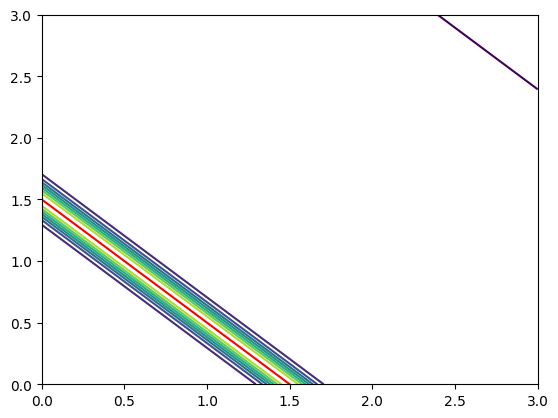

In [6]:
'''Analytical method'''
X2,X3 = np.meshgrid(np.linspace(a_2,b_2,grid_pts),np.linspace(a_3,b_3,grid_pts))
P_ = []
for j,k in zip(X2.flatten(), X3.flatten()):
    # term1 = 1/np.sqrt(2*np.pi*sig**2)
    # term2 = 1/np.sqrt(2*np.pi*sig_e**2)
    # term3 = np.exp(-((j+k)**2)/(2*sig_e**2))
    # term4 = np.exp(-(1.5**2)/(2*sig**2))
    # term5 = np.sqrt(np.pi/((1/(2*sig**2))+(1/(2*sig_e**2))))
    # term6 = np.exp((((1.5/(sig**2))+((j+k)/(sig_e**2)))**2)/(4*((1/(2*sig**2))+(1/(2*sig_e**2)))))
    term1 = 1/np.sqrt(2*np.pi*sig**2)
    term2 = 1/np.sqrt(2*np.pi*sig_e**2)
    term3 = -((j+k)**2)/(2*sig_e**2)
    term4 = -(y**2)/(2*sig**2)
    term5 = np.sqrt(np.pi/((1/(2*sig**2))+(1/(2*sig_e**2))))
    term6 = (((y/(sig**2))+((j+k)/(sig_e**2)))**2)/(4*((1/(2*sig**2))+(1/(2*sig_e**2))))
    P_.append( np.log(term1)+np.log(term2)+term3+term4+np.log(term5)+term6 )

plt.contour(X2, X3, np.exp(np.array(P_).reshape(X2.shape)))
plt.plot(np.linspace(a_2,y,1000), -1.0*np.linspace(a_2,y,1000)+y, 'r')